In [1]:
import os
import cv2
import numpy
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.utils import make_grid,save_image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DIR = "../input/faces-data-new"
os.listdir(DIR)

['images']

In [3]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
train_ds = ImageFolder(DIR,transform = tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.RandomHorizontalFlip(p=0.5),
    tt.ToTensor(),
    tt.Normalize(*stats)
]))
train_dl = DataLoader(train_ds,batch_size,shuffle = True,num_workers = 3, pin_memory = True)

In [4]:
def denorm(img_tensor):
    return img_tensor*stats[1][0] + stats[0][0]

In [5]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

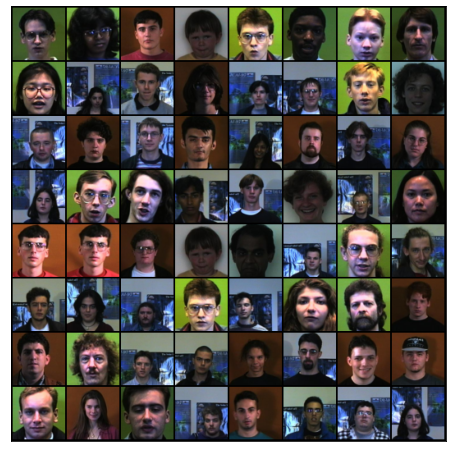

In [6]:
show_batch(train_dl)

In [7]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device, non_blocking = True)

class DeviceDataLoader():
    def __init__(self,dl,device):
        self.dl = dl
        self.device = device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b,device)
    def __len__(self):
        return len(self.dl)

In [8]:
device = get_default_device()
device

device(type='cuda')

In [9]:
train_dl = DeviceDataLoader(train_dl,device)

In [10]:
discriminator = nn.Sequential(

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),

    nn.Flatten(),
    nn.Sigmoid())

In [11]:
discriminator = to_device(discriminator,device)

In [12]:
latent_size = 128
generator = nn.Sequential(

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
)

torch.Size([128, 3, 64, 64])


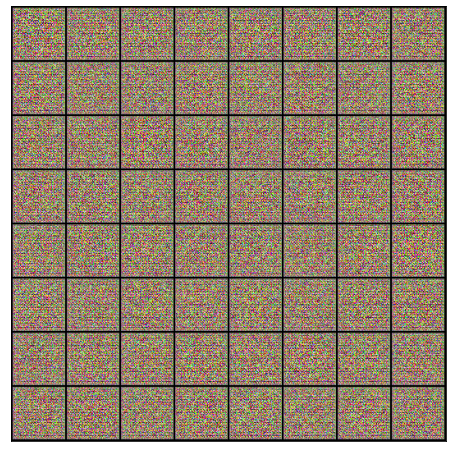

In [13]:
xb = torch.randn(batch_size,latent_size,1,1)
fake_image = generator(xb)
print(fake_image.shape)
show_images(fake_image)

In [14]:
generator = to_device(generator, device)

In [15]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [16]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [17]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [18]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    print(fake_images.size())
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [19]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)
fixed_latent.shape

torch.Size([64, 128, 1, 1])

torch.Size([64, 3, 64, 64])
Saving generated-images-0000.png


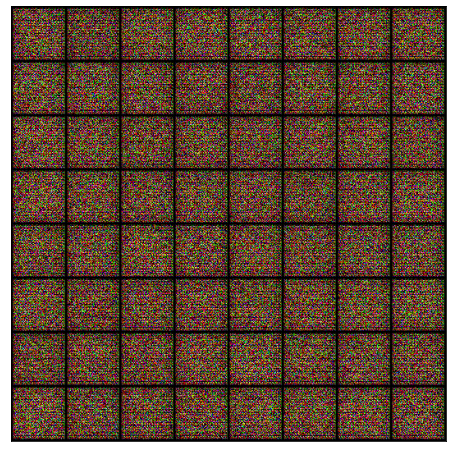

In [20]:
save_samples(0, fixed_latent)

In [21]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [22]:
lr = 0.0002
epochs = 60

In [23]:
history = fit(epochs, lr)


Epoch [1/60], loss_g: 4.9351, loss_d: 0.0958, real_score: 0.9419, fake_score: 0.0314
torch.Size([64, 3, 64, 64])
Saving generated-images-0001.png



Epoch [2/60], loss_g: 5.8775, loss_d: 0.0250, real_score: 0.9881, fake_score: 0.0125
torch.Size([64, 3, 64, 64])
Saving generated-images-0002.png



Epoch [3/60], loss_g: 6.8200, loss_d: 0.0251, real_score: 0.9888, fake_score: 0.0106
torch.Size([64, 3, 64, 64])
Saving generated-images-0003.png



Epoch [4/60], loss_g: 9.4837, loss_d: 0.3187, real_score: 0.9856, fake_score: 0.2244
torch.Size([64, 3, 64, 64])
Saving generated-images-0004.png



Epoch [5/60], loss_g: 3.5610, loss_d: 0.2039, real_score: 0.8950, fake_score: 0.0699
torch.Size([64, 3, 64, 64])
Saving generated-images-0005.png



Epoch [6/60], loss_g: 4.5150, loss_d: 0.5365, real_score: 0.9840, fake_score: 0.3558
torch.Size([64, 3, 64, 64])
Saving generated-images-0006.png



Epoch [7/60], loss_g: 4.7040, loss_d: 0.1792, real_score: 0.9604, fake_score: 0.1242
torch.Size([64, 3, 64, 64])
Saving generated-images-0007.png



Epoch [8/60], loss_g: 3.7908, loss_d: 0.1926, real_score: 0.9210, fake_score: 0.0949
torch.Size([64, 3, 64, 64])
Saving generated-images-0008.png



Epoch [9/60], loss_g: 4.9828, loss_d: 0.0954, real_score: 0.9505, fake_score: 0.0394
torch.Size([64, 3, 64, 64])
Saving generated-images-0009.png



Epoch [10/60], loss_g: 12.8631, loss_d: 1.8854, real_score: 0.9991, fake_score: 0.7653
torch.Size([64, 3, 64, 64])
Saving generated-images-0010.png



Epoch [11/60], loss_g: 2.1147, loss_d: 0.5574, real_score: 0.6704, fake_score: 0.0416
torch.Size([64, 3, 64, 64])
Saving generated-images-0011.png



Epoch [12/60], loss_g: 1.5638, loss_d: 0.6018, real_score: 0.6607, fake_score: 0.0403
torch.Size([64, 3, 64, 64])
Saving generated-images-0012.png



Epoch [13/60], loss_g: 3.4663, loss_d: 0.3941, real_score: 0.7569, fake_score: 0.0330
torch.Size([64, 3, 64, 64])
Saving generated-images-0013.png



Epoch [14/60], loss_g: 7.1817, loss_d: 0.5931, real_score: 0.9954, fake_score: 0.3633
torch.Size([64, 3, 64, 64])
Saving generated-images-0014.png



Epoch [15/60], loss_g: 4.6460, loss_d: 0.0947, real_score: 0.9255, fake_score: 0.0134
torch.Size([64, 3, 64, 64])
Saving generated-images-0015.png



Epoch [16/60], loss_g: 4.1720, loss_d: 0.1917, real_score: 0.8866, fake_score: 0.0575
torch.Size([64, 3, 64, 64])
Saving generated-images-0016.png



Epoch [17/60], loss_g: 3.2308, loss_d: 0.6615, real_score: 0.6006, fake_score: 0.0049
torch.Size([64, 3, 64, 64])
Saving generated-images-0017.png



Epoch [18/60], loss_g: 3.7683, loss_d: 0.1334, real_score: 0.9440, fake_score: 0.0676
torch.Size([64, 3, 64, 64])
Saving generated-images-0018.png



Epoch [19/60], loss_g: 5.4929, loss_d: 0.1494, real_score: 0.9856, fake_score: 0.1092
torch.Size([64, 3, 64, 64])
Saving generated-images-0019.png



Epoch [20/60], loss_g: 4.4658, loss_d: 0.2153, real_score: 0.8975, fake_score: 0.0782
torch.Size([64, 3, 64, 64])
Saving generated-images-0020.png



Epoch [21/60], loss_g: 3.9086, loss_d: 0.0576, real_score: 0.9637, fake_score: 0.0193
torch.Size([64, 3, 64, 64])
Saving generated-images-0021.png



Epoch [22/60], loss_g: 4.4107, loss_d: 0.0804, real_score: 0.9726, fake_score: 0.0483
torch.Size([64, 3, 64, 64])
Saving generated-images-0022.png



Epoch [23/60], loss_g: 3.5074, loss_d: 0.0763, real_score: 0.9505, fake_score: 0.0234
torch.Size([64, 3, 64, 64])
Saving generated-images-0023.png



Epoch [24/60], loss_g: 3.3238, loss_d: 0.1244, real_score: 0.9413, fake_score: 0.0569
torch.Size([64, 3, 64, 64])
Saving generated-images-0024.png



Epoch [25/60], loss_g: 3.9749, loss_d: 0.1012, real_score: 0.9459, fake_score: 0.0392
torch.Size([64, 3, 64, 64])
Saving generated-images-0025.png



Epoch [26/60], loss_g: 5.0727, loss_d: 0.0647, real_score: 0.9839, fake_score: 0.0457
torch.Size([64, 3, 64, 64])
Saving generated-images-0026.png



Epoch [27/60], loss_g: 3.4889, loss_d: 0.0819, real_score: 0.9378, fake_score: 0.0146
torch.Size([64, 3, 64, 64])
Saving generated-images-0027.png



Epoch [28/60], loss_g: 4.5865, loss_d: 0.0456, real_score: 0.9753, fake_score: 0.0195
torch.Size([64, 3, 64, 64])
Saving generated-images-0028.png



Epoch [29/60], loss_g: 4.3557, loss_d: 0.0661, real_score: 0.9793, fake_score: 0.0426
torch.Size([64, 3, 64, 64])
Saving generated-images-0029.png



Epoch [30/60], loss_g: 2.7784, loss_d: 0.1457, real_score: 0.8889, fake_score: 0.0206
torch.Size([64, 3, 64, 64])
Saving generated-images-0030.png



Epoch [31/60], loss_g: 4.2973, loss_d: 0.0866, real_score: 0.9682, fake_score: 0.0398
torch.Size([64, 3, 64, 64])
Saving generated-images-0031.png



Epoch [32/60], loss_g: 4.3596, loss_d: 0.0442, real_score: 0.9762, fake_score: 0.0193
torch.Size([64, 3, 64, 64])
Saving generated-images-0032.png



Epoch [33/60], loss_g: 5.6033, loss_d: 0.1197, real_score: 0.9798, fake_score: 0.0875
torch.Size([64, 3, 64, 64])
Saving generated-images-0033.png



Epoch [34/60], loss_g: 4.7530, loss_d: 0.0836, real_score: 0.9551, fake_score: 0.0340
torch.Size([64, 3, 64, 64])
Saving generated-images-0034.png



Epoch [35/60], loss_g: 4.3072, loss_d: 0.0355, real_score: 0.9762, fake_score: 0.0105
torch.Size([64, 3, 64, 64])
Saving generated-images-0035.png



Epoch [36/60], loss_g: 5.0934, loss_d: 0.0974, real_score: 0.9762, fake_score: 0.0674
torch.Size([64, 3, 64, 64])
Saving generated-images-0036.png



Epoch [37/60], loss_g: 3.4543, loss_d: 0.1128, real_score: 0.9341, fake_score: 0.0395
torch.Size([64, 3, 64, 64])
Saving generated-images-0037.png



Epoch [38/60], loss_g: 4.7187, loss_d: 0.1583, real_score: 0.8938, fake_score: 0.0270
torch.Size([64, 3, 64, 64])
Saving generated-images-0038.png



Epoch [39/60], loss_g: 5.2509, loss_d: 0.0414, real_score: 0.9709, fake_score: 0.0105
torch.Size([64, 3, 64, 64])
Saving generated-images-0039.png



Epoch [40/60], loss_g: 5.1996, loss_d: 0.0502, real_score: 0.9677, fake_score: 0.0156
torch.Size([64, 3, 64, 64])
Saving generated-images-0040.png



Epoch [41/60], loss_g: 6.5222, loss_d: 0.0709, real_score: 0.9653, fake_score: 0.0331
torch.Size([64, 3, 64, 64])
Saving generated-images-0041.png



Epoch [42/60], loss_g: 5.2035, loss_d: 0.0715, real_score: 0.9421, fake_score: 0.0024
torch.Size([64, 3, 64, 64])
Saving generated-images-0042.png



Epoch [43/60], loss_g: 5.1536, loss_d: 0.0687, real_score: 0.9427, fake_score: 0.0062
torch.Size([64, 3, 64, 64])
Saving generated-images-0043.png



Epoch [44/60], loss_g: 3.7468, loss_d: 0.0398, real_score: 0.9877, fake_score: 0.0262
torch.Size([64, 3, 64, 64])
Saving generated-images-0044.png



Epoch [45/60], loss_g: 4.8155, loss_d: 0.0330, real_score: 0.9924, fake_score: 0.0246
torch.Size([64, 3, 64, 64])
Saving generated-images-0045.png



Epoch [46/60], loss_g: 7.0454, loss_d: 0.1226, real_score: 0.9092, fake_score: 0.0139
torch.Size([64, 3, 64, 64])
Saving generated-images-0046.png



Epoch [47/60], loss_g: 6.5810, loss_d: 0.0410, real_score: 0.9817, fake_score: 0.0215
torch.Size([64, 3, 64, 64])
Saving generated-images-0047.png



Epoch [48/60], loss_g: 5.1606, loss_d: 0.0393, real_score: 0.9837, fake_score: 0.0220
torch.Size([64, 3, 64, 64])
Saving generated-images-0048.png



Epoch [49/60], loss_g: 5.4336, loss_d: 0.0300, real_score: 0.9834, fake_score: 0.0128
torch.Size([64, 3, 64, 64])
Saving generated-images-0049.png



Epoch [50/60], loss_g: 2.6576, loss_d: 0.1346, real_score: 0.9040, fake_score: 0.0205
torch.Size([64, 3, 64, 64])
Saving generated-images-0050.png



Epoch [51/60], loss_g: 4.6079, loss_d: 0.0626, real_score: 0.9617, fake_score: 0.0217
torch.Size([64, 3, 64, 64])
Saving generated-images-0051.png



Epoch [52/60], loss_g: 5.1908, loss_d: 0.0502, real_score: 0.9895, fake_score: 0.0376
torch.Size([64, 3, 64, 64])
Saving generated-images-0052.png



Epoch [53/60], loss_g: 5.0523, loss_d: 0.0855, real_score: 0.9823, fake_score: 0.0620
torch.Size([64, 3, 64, 64])
Saving generated-images-0053.png



Epoch [54/60], loss_g: 5.0137, loss_d: 0.5580, real_score: 0.7954, fake_score: 0.0314
torch.Size([64, 3, 64, 64])
Saving generated-images-0054.png



Epoch [55/60], loss_g: 6.4700, loss_d: 0.1190, real_score: 0.9959, fake_score: 0.0989
torch.Size([64, 3, 64, 64])
Saving generated-images-0055.png



Epoch [56/60], loss_g: 5.1494, loss_d: 0.1020, real_score: 0.9804, fake_score: 0.0746
torch.Size([64, 3, 64, 64])
Saving generated-images-0056.png



Epoch [57/60], loss_g: 4.7267, loss_d: 0.0217, real_score: 0.9924, fake_score: 0.0137
torch.Size([64, 3, 64, 64])
Saving generated-images-0057.png



Epoch [58/60], loss_g: 4.2154, loss_d: 0.0492, real_score: 0.9604, fake_score: 0.0072
torch.Size([64, 3, 64, 64])
Saving generated-images-0058.png



Epoch [59/60], loss_g: 6.2775, loss_d: 0.0380, real_score: 0.9890, fake_score: 0.0257
torch.Size([64, 3, 64, 64])
Saving generated-images-0059.png



Epoch [60/60], loss_g: 5.5458, loss_d: 0.0268, real_score: 0.9841, fake_score: 0.0103
torch.Size([64, 3, 64, 64])
Saving generated-images-0060.png


In [24]:
losses_g, losses_d, real_scores, fake_scores = history

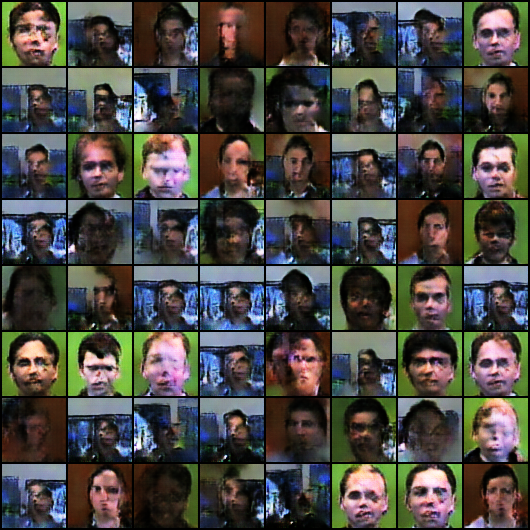

In [25]:
from IPython.display import Image
Image('./generated/generated-images-0060.png')

In [26]:
vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

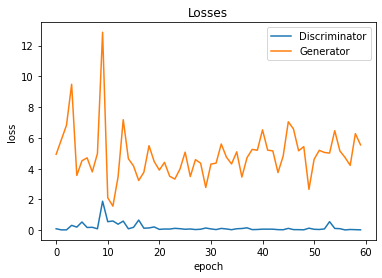

In [27]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

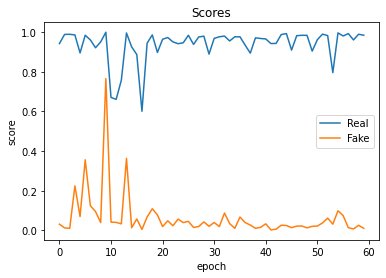

In [28]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');